# Đọc File

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
!pip install squarify
import squarify
from datetime import datetime

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
input_path = "rfm_output.csv"
rfm_df = pd.read_csv(input_path)
rfm_data = rfm_df[['Member_number','Frequency', 'Recency', 'Monetary']].set_index('Member_number')

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
#Chuẩn hóa
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)

In [6]:
# Tính WCSS cho nhiều giá trị k
wcss = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

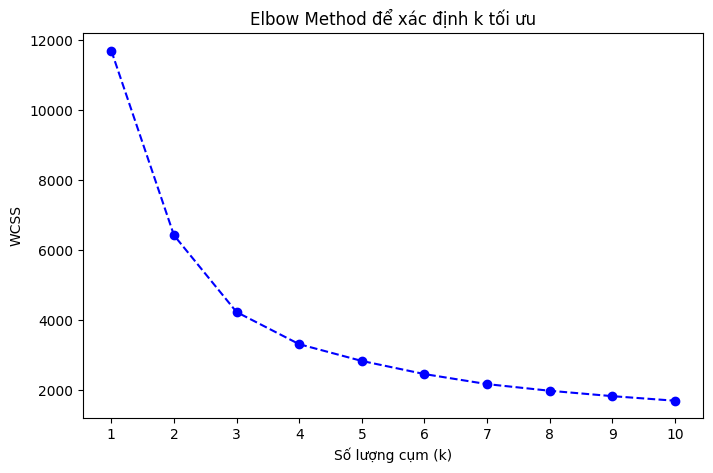

In [7]:
# Vẽ biểu đồ Elbow
plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, marker='o', linestyle='--', color='b')
plt.xlabel('Số lượng cụm (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method để xác định k tối ưu')
plt.xticks(K_range)
plt.show()

In [8]:
# Build model with k=3
model = KMeans(n_clusters=3, random_state=42)
model.fit(rfm_data)
model.labels_.shape

(3898,)

In [9]:
rfm_data["Cluster"] = model.labels_
rfm_data.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         70.23     11.77   101.75  2120
1        494.05      5.23    43.41   543
2        254.67      8.89    75.20  1235

In [10]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg2 = rfm_data.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg2.columns = rfm_agg2.columns.droplevel()
rfm_agg2.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg2['Percent'] = round((rfm_agg2['Count']/rfm_agg2.Count.sum())*100, 2)

# Reset the index
rfm_agg2 = rfm_agg2.reset_index()

# Change thr Cluster Columns Datatype into discrete values
rfm_agg2['Cluster'] = 'Cluster '+ rfm_agg2['Cluster'].astype('str')

# Print the aggregated dataset
rfm_agg2

,Cluster,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,Cluster 0,70.0,12.0,102.0,2120,54.39
1,Cluster 1,494.0,5.0,43.0,543,13.93
2,Cluster 2,255.0,9.0,75.0,1235,31.68


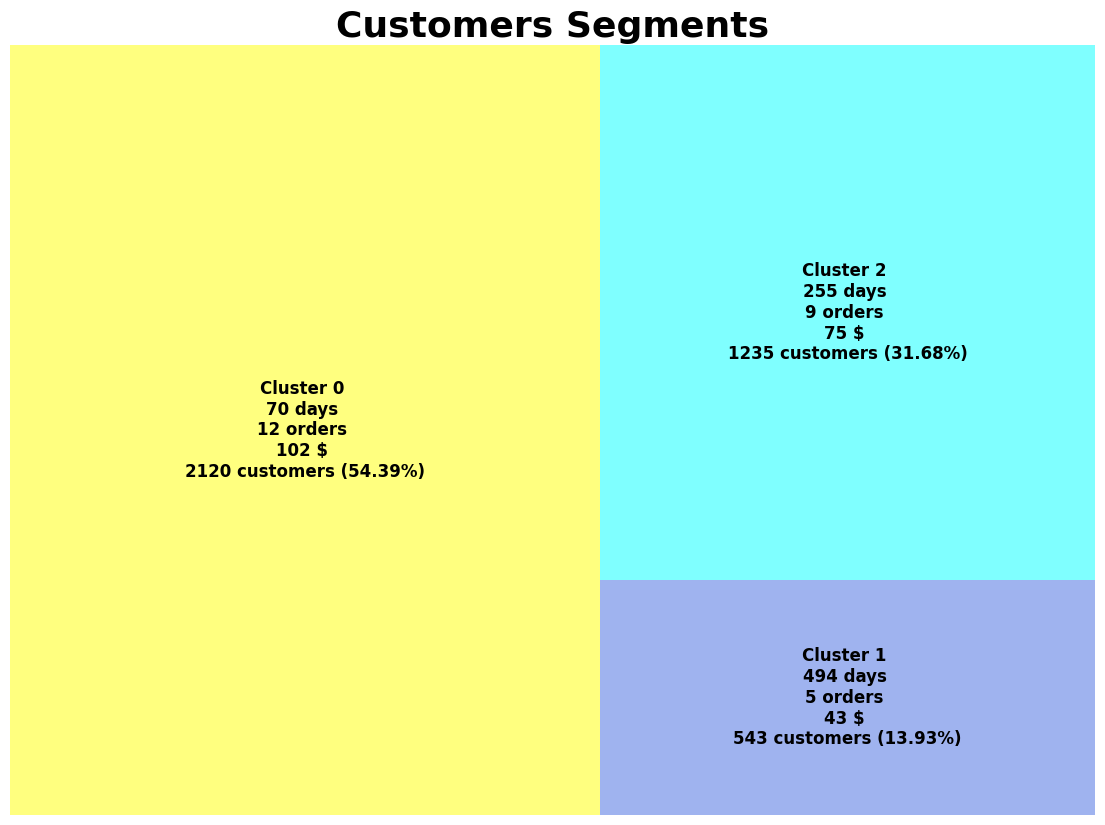

In [11]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple'}

squarify.plot(sizes=rfm_agg2['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg2.iloc[i])
                      for i in range(0, len(rfm_agg2))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.show()

In [12]:
import plotly.express as px

fig = px.scatter(rfm_agg2, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
           hover_name="Cluster", size_max=100)
fig.show()

### Summary
Từ 2 biểu đồ trên, ta có thể thấy:
- Cụm khách hàng 0 là cụm khách hàng có R thấp và F, M cao, Chứng tỏ họ là khách hàng VIP, cần thêm ưu đãi để tri ân khách hàng

- Cụm khách hàng 1 là cụm khách hàng có R cao và F, M thấp, Trái ngược hoàn toàn với Cụm khách hàng 0, họ có thể đã rời bỏ cửa hàng hoặc là khách du lịch

- Cụm khách hàng 2 là cụm khách hàng có R trung bình, F khá cao và M trung bình cao, họ là những khách hàng quen biết, ít khi ghé, cần thêm khuyến mãi

- Cụm khách hàng 3 là cụm khách hàng có R khá cao, F và M trung bình thấp, họ là khách hàng có nguy cơ rời bỏ cửa hàng rất cao, cần thêm khuyến mãi

- Cụm khách hàng 4 là cụm khách hàng có R cao nhất, F khá cao và M trung bình thấp, họ là khách hàng thường xuyên ghé nhưng mức độ chi tiêu không cao, cần khuyến mãi thêm

# Hierachical

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
rfm_data2 = rfm_df[['Member_number','Frequency', 'Recency', 'Monetary']].set_index('Member_number')
rfm_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3898 entries, 2433 to 1250
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Frequency  3898 non-null   int64  
 1   Recency    3898 non-null   int64  
 2   Monetary   3898 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 121.8 KB


In [14]:
rfm_data2.head()

,Frequency,Recency,Monetary
Member_number,,,
2433,31,3,375.31
2193,27,91,361.45
1793,25,26,345.10
3289,29,4,334.15
2743,17,142,312.46


In [15]:
#Chuẩn hóa
scaler = StandardScaler()
rfm_scaled2 = scaler.fit_transform(rfm_data2)

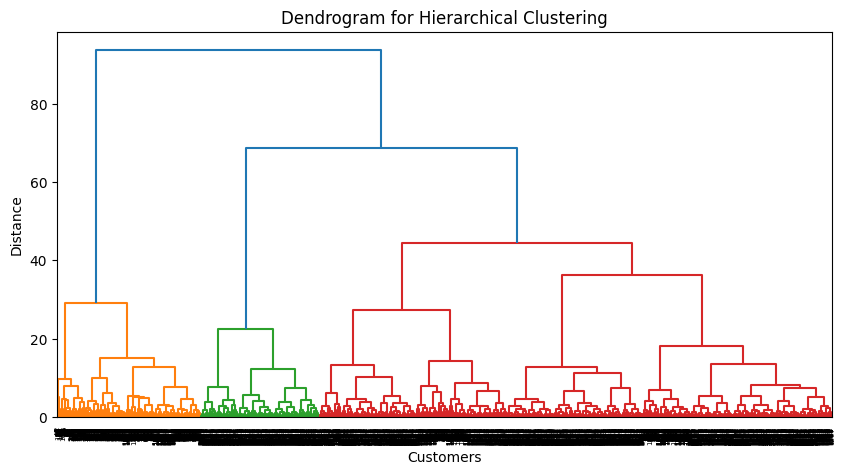

In [16]:
plt.figure(figsize=(10, 5))
linkage_matrix = linkage(rfm_scaled2, method='ward')
dendrogram(linkage_matrix)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Customers")
plt.ylabel("Distance")
plt.show()

In [17]:
n_clusters = 3
agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
rfm_data2['Cluster'] = agg_cluster.fit_predict(rfm_scaled2)

In [18]:
rfm_data2.loc[:, 'Cluster'] = agg_cluster.labels_

rfm_agg3 = rfm_data2.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count'
}).round(2)

In [19]:
rfm_agg3.columns = ['RecencyMean', 'FrequencyMean', 'MonetaryMean', 'Count']

# Tính phần trăm của từng cụm
rfm_agg3['Percent'] = round((rfm_agg3['Count'] / rfm_agg3['Count'].sum()) * 100, 2)

# Reset lại index để dễ thao tác hơn
rfm_agg3 = rfm_agg3.reset_index()

# Chuyển cột Cluster về dạng chuỗi để tiện cho việc xử lý trực quan
rfm_agg3['Cluster'] = rfm_agg3['Cluster'].astype(str)

# Hiển thị kết quả
print(rfm_agg3)

  Cluster  RecencyMean  FrequencyMean  MonetaryMean  Count  Percent
0       0       156.90           9.05         74.94   2575    66.06
1       1        83.36          17.97        167.96    726    18.62
2       2       447.46           4.06         28.87    597    15.32


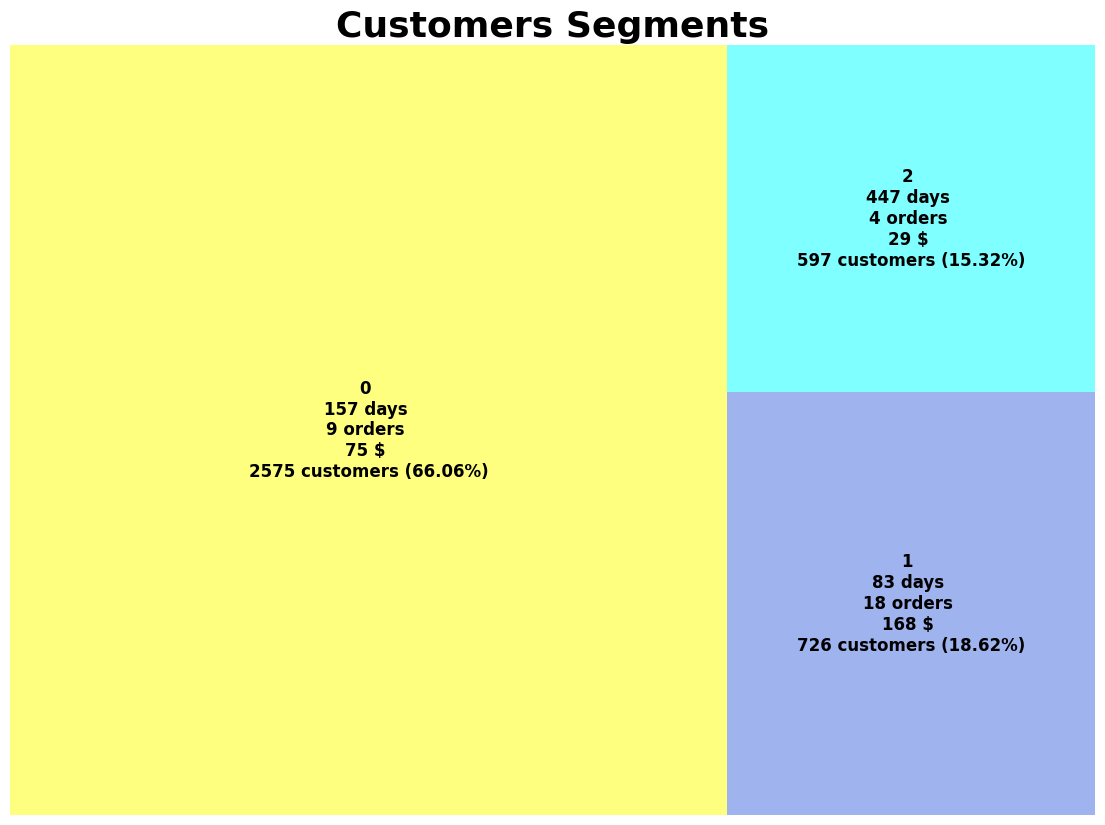

In [20]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14, 10)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple'}

squarify.plot(sizes=rfm_agg3['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg3.iloc[i])
                      for i in range(0, len(rfm_agg3))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')
plt.show()

In [21]:
import plotly.express as px

fig = px.scatter(rfm_agg3, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
           hover_name="Cluster", size_max=100)
fig.show()

In [22]:
import pickle

# Lưu KMeans model
with open("kmeans_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Lưu StandardScaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


In [23]:
# Lưu mô hình Agglomerative Clustering
with open("hierarchical_model.pkl", "wb") as f:
    pickle.dump(agg_cluster, f)

# Lưu StandardScaler (có thể trùng với scaler của KMeans nếu bạn dùng lại)
with open("scaler_hierarchical.pkl", "wb") as f:
    pickle.dump(scaler, f)
